In [1]:
# read from /opt
!ls /opt/textbooks/chunk/

Anatomy_Gray.jsonl	       Neurology_Adams.jsonl
Biochemistry_Lippincott.jsonl  Obstentrics_Williams.jsonl
Cell_Biology_Alberts.jsonl     Pathology_Robbins.jsonl
First_Aid_Step1.jsonl	       Pathoma_Husain.jsonl
First_Aid_Step2.jsonl	       Pediatrics_Nelson.jsonl
Gynecology_Novak.jsonl	       Pharmacology_Katzung.jsonl
Histology_Ross.jsonl	       Physiology_Levy.jsonl
Immunology_Janeway.jsonl       Psichiatry_DSM-5.jsonl
InternalMed_Harrison.jsonl     Surgery_Schwartz.jsonl


In [2]:
# read from /opt/textbooks/chunk/Anatomy_Gray.jsonl
import json
import pandas as pd
# read the jsonl file to pandas dataframe
anatomy = pd.read_json('/opt/textbooks/chunk/Anatomy_Gray.jsonl', lines=True)
print(anatomy.head())
print(anatomy.shape)
print(anatomy.columns)


               id         title  \
0  Anatomy_Gray_0  Anatomy_Gray   
1  Anatomy_Gray_1  Anatomy_Gray   
2  Anatomy_Gray_2  Anatomy_Gray   
3  Anatomy_Gray_3  Anatomy_Gray   
4  Anatomy_Gray_4  Anatomy_Gray   

                                             content  \
0  What is anatomy? Anatomy includes those struct...   
1  Observation and visualization are the primary ...   
2  How can gross anatomy be studied? The term ana...   
3  This includes the vasculature, the nerves, the...   
4  Each of these approaches has benefits and defi...   

                                            contents  
0  Anatomy_Gray. What is anatomy? Anatomy include...  
1  Anatomy_Gray. Observation and visualization ar...  
2  Anatomy_Gray. How can gross anatomy be studied...  
3  Anatomy_Gray. This includes the vasculature, t...  
4  Anatomy_Gray. Each of these approaches has ben...  
(3017, 4)
Index(['id', 'title', 'content', 'contents'], dtype='object')


In [8]:
# parse jsonl file
import json

data = []
with open('/opt/textbooks/chunk/Anatomy_Gray.jsonl', "r") as f:
    for line in f:
        data.append(json.loads(line))

In [9]:
text_to_process = data[0]

In [2]:
# clean data
import pandas as pd
import re

df = pd.DataFrame(data)
df['content_cleaned'] = df['content'].apply(lambda x: re.sub(r'\s+', ' ', x.lower()))


In [16]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

[nltk_data] Downloading package stopwords to /home/ganesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ganesh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ganesh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
def clean_text(text):
    # Tokenize the text into words
    words = text.split()

    # Remove special characters and convert to lowercase
    clean_words = [word.lower() for word in words if word.isalnum()]

    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    filtered_words = [word for word in clean_words if word not in stop_words]

    # Remove words with less than 4 characters and numbers. This is done in order to reduce noisy data and numbers dont contribute much in any NLP applications
    filtered_words = [word for word in filtered_words if len(word) >= 4 and not word.isdigit()]

    # Remove duplicate words
    cleaned_text = " ".join(dict.fromkeys(filtered_words))  # This is useful while plotting t-SNE plots

    return cleaned_text

In [14]:
import numpy as np
from sklearn.manifold import TSNE
import string
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer
import torch

# Load the BERT model and tokenizer
clinical_model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
clinical_tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
clinical_model.eval()


# Example input text
input_text = clean_text(text_to_process['content'])

# Tokenize the input text using the BERT tokenizer
#input_tokens = clinical_tokenizer.tokenize(input_text)
input_tokens = input_text.split()
# Initialize an empty list to store word embeddings
word_embs = []

for token in input_tokens:
    # Check if the token is a valid word
    if token not in string.punctuation:
        # Encode the token using the BERT model
        inputs = clinical_tokenizer(token, return_tensors="pt")
        with torch.no_grad():
            outputs = clinical_model(**inputs)
        token_emb = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        word_embs.append(token_emb)


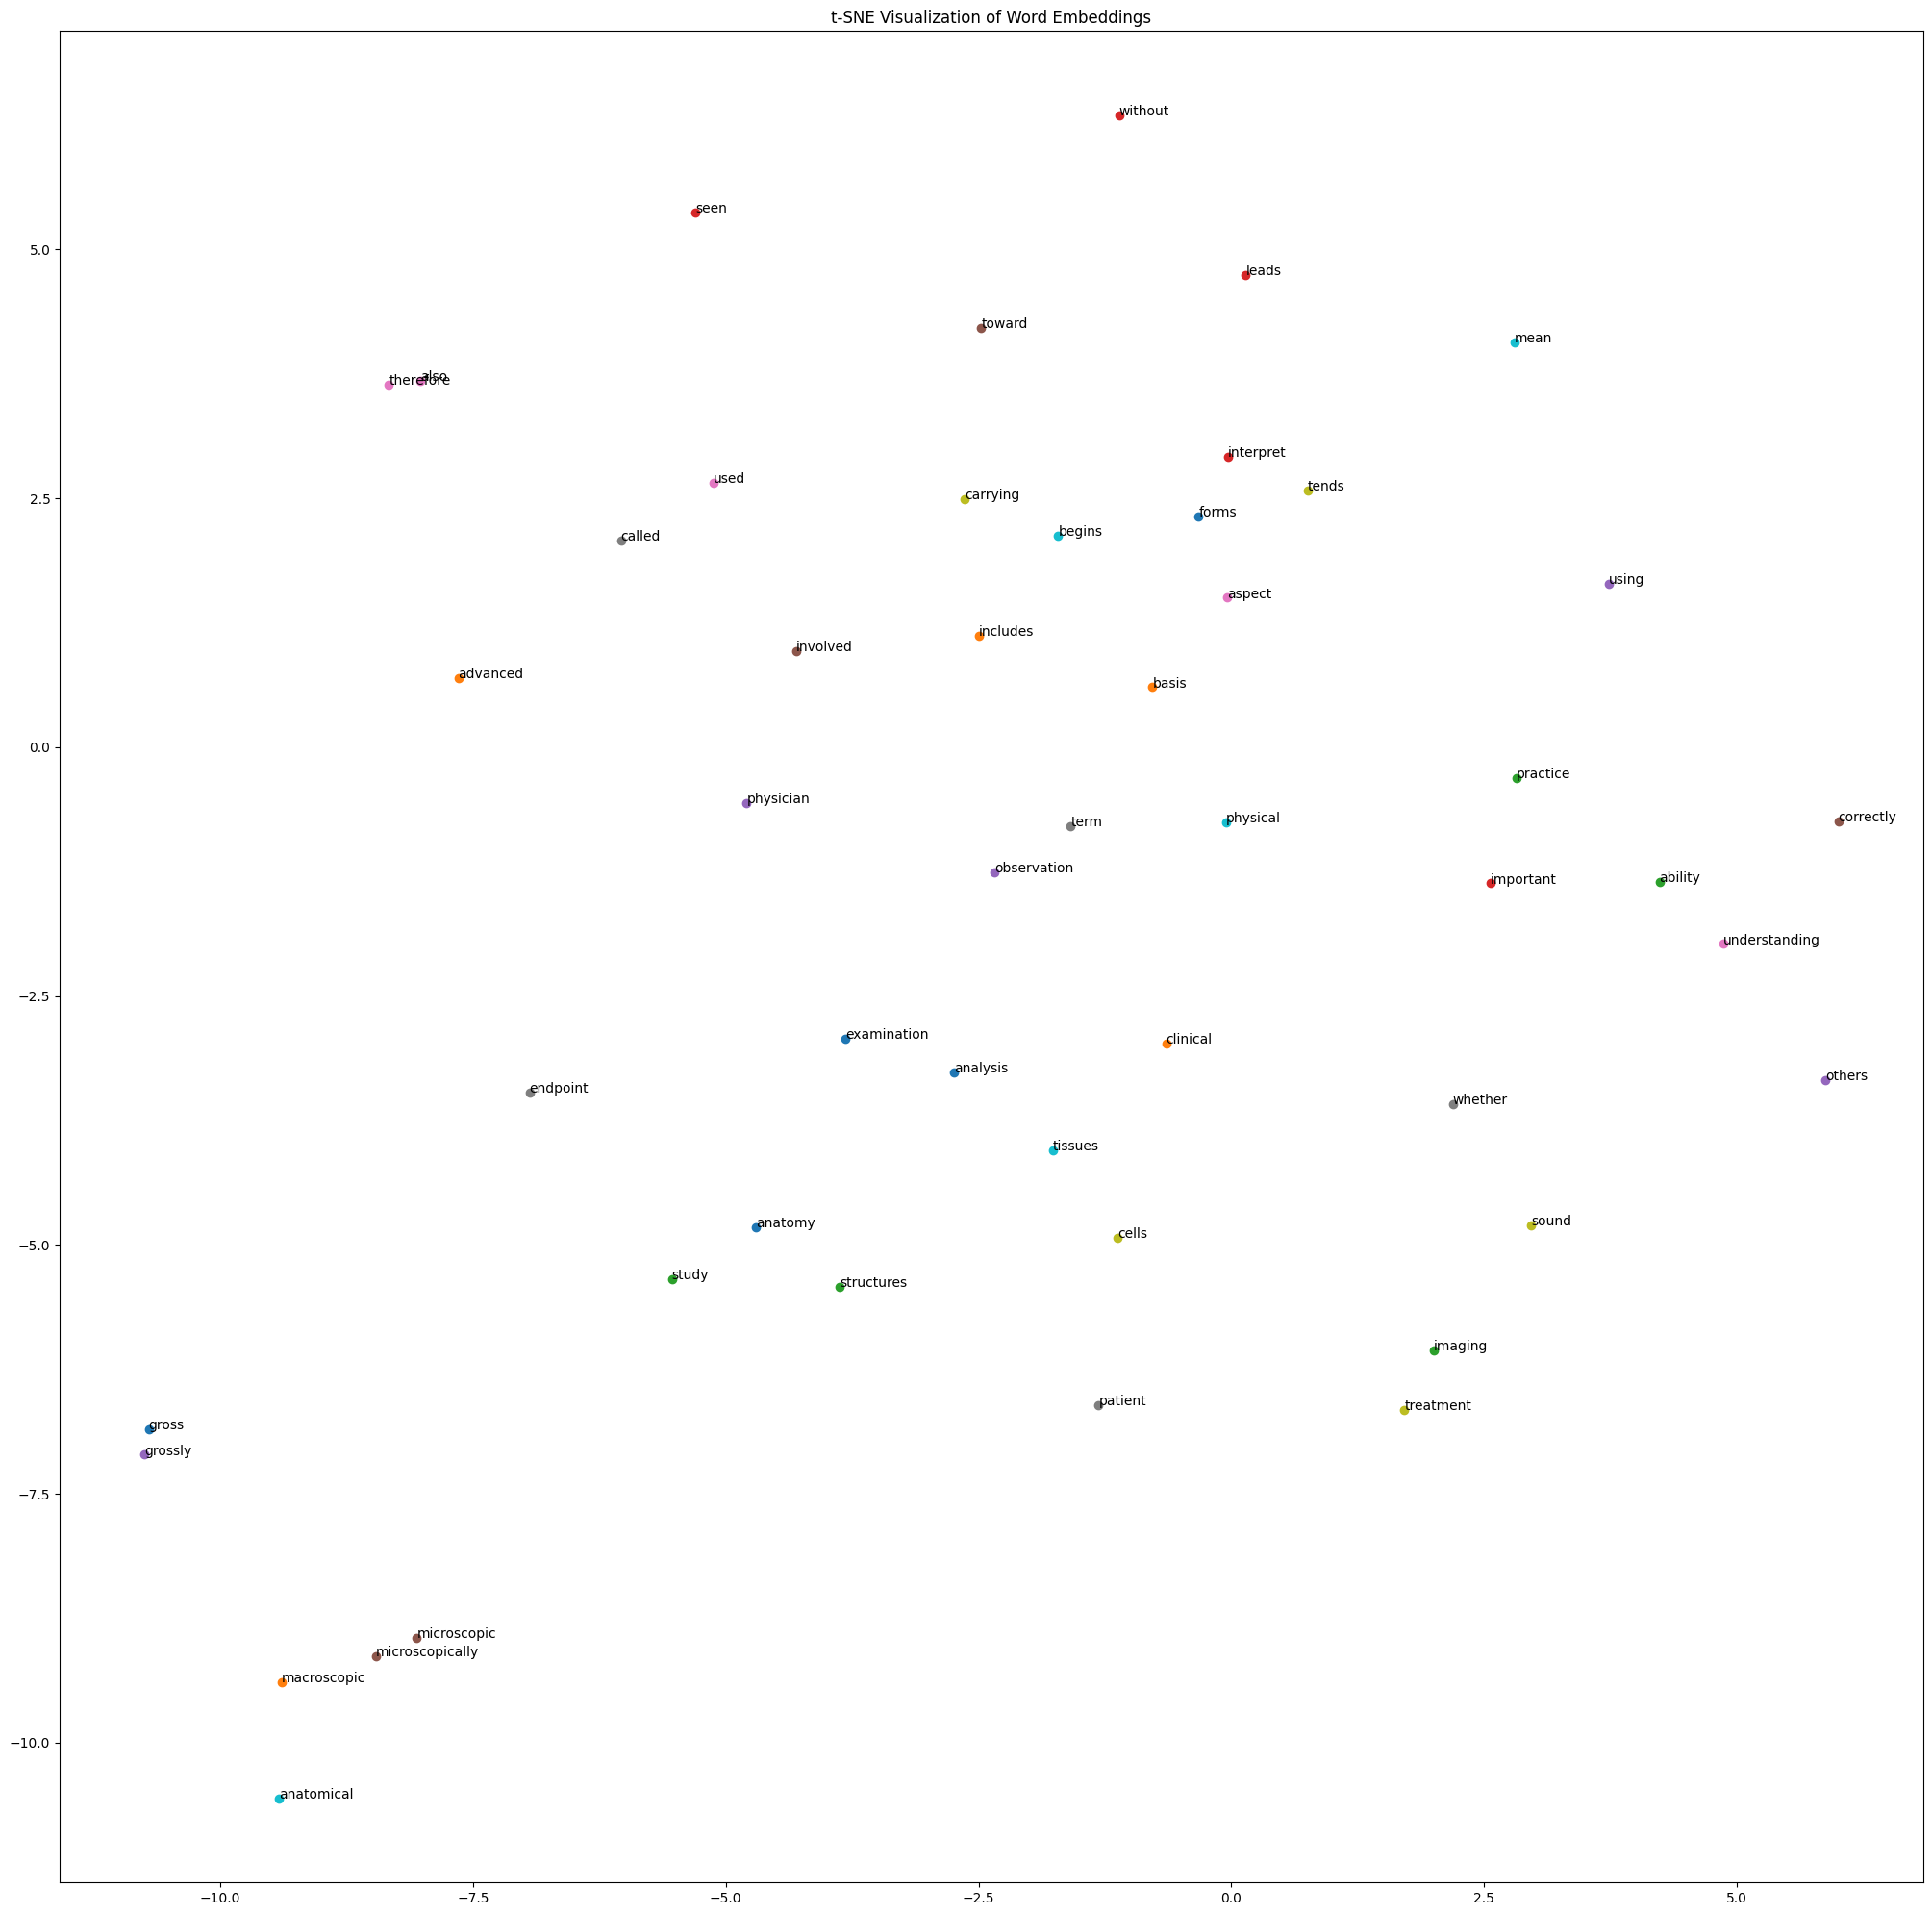

In [13]:
# Perform t-SNE dimensionality reduction
tsne_model = TSNE(n_components=2, perplexity=10, random_state=42)
word_embs_2d = tsne_model.fit_transform(np.array(word_embs))

# Create a scatter plot of the word embeddings in 2D space
plt.figure(figsize=(25, 25))
for i in range(len(word_embs_2d)):
    plt.scatter(word_embs_2d[i, 0], word_embs_2d[i, 1])
    plt.annotate(input_tokens[i], (word_embs_2d[i, 0], word_embs_2d[i, 1]))

plt.title("t-SNE Visualization of Word Embeddings")
plt.show()

In [10]:
from sentence_transformers import SentenceTransformer
# Initialize SentenceTransformer for embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
input_text = clean_text(text_to_process['content'])
vector = model.encode(input_text).tolist()  # Generate vector
print(vector)
    

/home/ganesh/.conda/envs/pytorch-rl-ds/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/ganesh/.conda/envs/pytorch-rl-ds/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


NameError: name 'clean_text' is not defined

In [13]:
text_to_process

{'id': 'Anatomy_Gray_0',
 'title': 'Anatomy_Gray',
 'content': 'What is anatomy? Anatomy includes those structures that can be seen grossly (without the aid of magnification) and microscopically (with the aid of magnification). Typically, when used by itself, the term anatomy tends to mean gross or macroscopic anatomy—that is, the study of structures that can be seen without using a microscopic. Microscopic anatomy, also called histology, is the study of cells and tissues using a microscope. Anatomy forms the basis for the practice of medicine. Anatomy leads the physician toward an understanding of a patient’s disease, whether he or she is carrying out a physical examination or using the most advanced imaging techniques. Anatomy is also important for dentists, chiropractors, physical therapists, and all others involved in any aspect of patient treatment that begins with an analysis of clinical signs. The ability to interpret a clinical observation correctly is therefore the endpoint of

In [23]:
insert_documents_to_weaviate(None)

In [9]:
from neo4j import GraphDatabase

# Define the URI, username, and password
uri = "bolt://localhost:7687"  # This is the default URI for local Neo4j
username = "neo4j"             # Replace with your username
password = ""     # Replace with your password

# Initialize the driver
#driver = GraphDatabase.driver(uri, auth=(username, password))
driver = GraphDatabase.driver(uri, encrypted=False)  

# Define a function to execute Cypher queries
def run_query(query):
    with driver.session() as session:
        result = session.run(query)
        return [record for record in result]

# Example query to return all nodes in the database
query = "MATCH (n) RETURN n LIMIT 5"
result = run_query(query)

# Display the results
for record in result:
    print(record)


In [26]:
print(input_tokens)

['anatomy', 'includes', 'structures', 'seen', 'grossly', 'microscopically', 'used', 'term', 'tends', 'mean', 'gross', 'macroscopic', 'study', 'without', 'using', 'microscopic', 'also', 'called', 'cells', 'tissues', 'forms', 'basis', 'practice', 'leads', 'physician', 'toward', 'understanding', 'whether', 'carrying', 'physical', 'examination', 'advanced', 'imaging', 'important', 'others', 'involved', 'aspect', 'patient', 'treatment', 'begins', 'analysis', 'clinical', 'ability', 'interpret', 'observation', 'correctly', 'therefore', 'endpoint', 'sound', 'anatomical']


In [38]:
def insert_entities_to_neo4j(documents):
    with driver.session() as session:
        #for doc in documents:
            # Extract entities (assuming already extracted)
        for i in range(len(input_tokens)):
            session.run("""
            MERGE (d:Document {id: $doc_id, title: $doc_title})
            MERGE (e:Entity {name: $entity_name})
            MERGE (d)-[:HAS_ENTITY]->(e)
            """, {
                "doc_id": text_to_process['id'],
                "doc_title": text_to_process['title'],
                "entity_name": input_tokens[i],
                "entity_embedding": word_embs[i].tolist()
                
            })


In [39]:
insert_entities_to_neo4j(None)


In [40]:

# Query Weaviate for relevant documents
query = "What is human anatomy and it impacts health?"



In [ ]:
# Retrieve graph relationships for a document
doc_id = "1"
graph_data = get_graph_relationships(doc_id)
print("Graph Relationships:", graph_data)

In [42]:
input_tokens

['human', 'anatomy', 'impacts']

In [43]:
with driver.session() as session:
        result = session.run("""
        MATCH (e:Entity)-[:RELATED_TO]->(r)
        WHERE e.name CONTAINS $query
        RETURN e.name AS entity, r.name AS related_entity, labels(r) AS community
        """, {"query": input_tokens[0]})

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownRelationshipTypeWarning} {category: UNRECOGNIZED} {title: The provided relationship type is not in the database.} {description: One of the relationship types in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing relationship type is: RELATED_TO)} {position: line: 2, column: 28, offset: 28} for query: '\n        MATCH (e:Entity)-[:RELATED_TO]->(r)\n        WHERE e.name CONTAINS $query\n        RETURN e.name AS entity, r.name AS related_entity, labels(r) AS community\n        '


In [47]:
from sklearn.metrics.pairwise import cosine_similarity

def insert_entities_with_relationships(session, input_tokens):
    for i in range(len(input_tokens)):
        # Insert Document and Entity nodes with HAS_ENTITY relationship
        session.run("""
        MERGE (d:Document {id: $doc_id, title: $doc_title})
        MERGE (e:Entity {name: $entity_name,  embedding: $entity_embedding})
        MERGE (d)-[:HAS_ENTITY]->(e)
        MERGE (e)-[:IN_DOCUMENT]->(d)
        """, {
            "doc_id": text_to_process['id'],
            "doc_title": text_to_process['title'],
            "entity_name": input_tokens[i],  # Adjusted for explicit field names
            
            "entity_embedding": word_embs[i].tolist() # Storing the embedding vector
        })

    # Add relationships between entities based on embedding similarity
    entity_embeddings = {input_tokens[i]: word_embs[i] for i in range(len(input_tokens))}
    entity_names = list(entity_embeddings.keys())
    embeddings = list(entity_embeddings.values())

    # Compute pairwise cosine similarity
    similarity_matrix = cosine_similarity(embeddings)

    for i in range(len(entity_names)):
        for j in range(i + 1, len(entity_names)):
            if similarity_matrix[i][j] > 0.8:  # Threshold for similarity
                session.run("""
                MATCH (e1:Entity {name: $entity1_name}), (e2:Entity {name: $entity2_name})
                MERGE (e1)-[:RELATED_TO {similarity: $similarity}]->(e2)
                """, {
                    "entity1_name": entity_names[i],
                    "entity2_name": entity_names[j],
                    "similarity": similarity_matrix[i][j]
                })


In [48]:
insert_entities_with_relationships(driver.session(), input_tokens)

In [14]:
%pip install elasticsearch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.1/543.1 kB 8.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 8.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
# load .env file
from dotenv import load_dotenv
import os
load_dotenv()


True

In [ ]:

!curl --cacert "http_ca.crt" -u elastic:$ELASTIC_PASSWORD https://localhost:9200


zrx48E9La*2Whl19iON7
{
  "name" : "503424cc0b4b",
  "cluster_name" : "docker-cluster",
  "cluster_uuid" : "CKvKVlXZTiiNKAXhCHrteA",
  "version" : {
    "number" : "8.16.1",
    "build_flavor" : "default",
    "build_type" : "docker",
    "build_hash" : "ffe992aa682c1968b5df375b5095b3a21f122bf3",
    "build_date" : "2024-11-19T16:00:31.793213192Z",
    "build_snapshot" : false,
    "lucene_version" : "9.12.0",
    "minimum_wire_compatibility_version" : "7.17.0",
    "minimum_index_compatibility_version" : "7.0.0"
  },
  "tagline" : "You Know, for Search"
}


In [3]:
from elasticsearch import Elasticsearch, helpers

# Initialize ElasticSearch client
es = Elasticsearch(hosts=["https://localhost:9200"],ca_certs="http_ca.crt",basic_auth=("elastic", os.getenv("ELASTIC_PASSWORD")))

# Example documents
documents = [
    {
        "_index": "documents",
        "_id": "1",
        "_source": {
            "file_name": "doc1.txt",
            "line_number": 1,
            "entity": "diabetes",
            "content": "Diabetes is a chronic disease that affects the metabolism."
        }
    },
    {
        "_index": "documents",
        "_id": "2",
        "_source": {
            "file_name": "doc1.txt",
            "line_number": 2,
            "entity": "insulin",
            "content": "Insulin is used to manage blood sugar levels."
        }
    }
]

# Bulk insert
helpers.bulk(es, documents)


(2, [])

In [3]:
from elasticsearch import Elasticsearch, helpers
import os
# Initialize ElasticSearch client
es = Elasticsearch(hosts=["https://localhost:9200"],ca_certs="http_ca.crt",basic_auth=("elastic", os.getenv("ELASTIC_PASSWORD")))
response = es.search(
    index="documents",
    body={
        "query": {
            "match": {
                "entity": "diabetes"
            }
        },
        "size": 10
    }
)
print(response)
# Extract results
for hit in response['hits']['hits']:
    print(f"File: {hit['_source']['file_name']}, Text: {hit['_source']['content']}")


{'took': 3, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 1, 'relation': 'eq'}, 'max_score': 0.6931471, 'hits': [{'_index': 'documents', '_id': '1', '_score': 0.6931471, '_source': {'file_name': 'doc1.txt', 'line_number': 1, 'entity': 'diabetes', 'content': 'Diabetes is a chronic disease that affects the metabolism.'}}]}}
File: doc1.txt, Text: Diabetes is a chronic disease that affects the metabolism.


# Go to the Neo4j Graph Data Science Download Page.
# Install GDS plugin in Neo4j
- Download the appropriate GDS version for your Neo4j installation.
- Place the downloaded .jar file into the plugins directory.
- sudo chmod 644 /var/lib/neo4j/plugins/neo4j-graph-data-science-*.jar


- On Linux: /var/lib/neo4j/plugins/
- On Windows: C:\Program Files\Neo4j\plugins
- On macOS: /Users/<your-username>/Library/Application Support/Neo4j - Desktop/Application/relate-data/dbmss/<instance-id>/plugins

- Enable  GDS Plugin
* dbms.security.procedures.unrestricted=gds.*
* dbms.security.procedures.allowlist=gds.*

- sudo systemctl restart neo4j






# Improve Neo4j performance
- Create index on entity (CREATE INDEX FOR (e:Entity) ON (e.name))
- Batch processing of Large files
- Use APOC for Bulk operations



In [21]:
# Bulk insert
from neo4j import GraphDatabase
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

class Neo4jBulkInserter:
    def __init__(self, uri):
        self.driver = GraphDatabase.driver(uri)

    def close(self):
        self.driver.close()

  

    def insert_entities_and_relationships(self, entities, threshold=0.75):
        with self.driver.session() as session:
            # Step 1: Insert all entities in bulk
            session.run("""
            UNWIND $entities AS entity
            MERGE (e:Entity {name: entity.name})
            SET e.embedding = entity.embedding
            """, {"entities": [{"name": e["name"], "embedding": e["embedding"]} for e in entities]})

            # Step 2: Calculate pairwise similarity and create relationships in bulk
            similarities = []
            for i, entity1 in enumerate(entities):
                for j, entity2 in enumerate(entities):
                    if i < j:  # Avoid duplicate and self-pairs
                        sim = cosine_similarity(
                            [entity1["embedding"]],
                            [entity2["embedding"]]
                        )[0][0]
                        if sim >= threshold:
                            similarities.append({
                                "entity1": entity1["name"],
                                "entity2": entity2["name"],
                                "similarity": sim
                            })

            # Step 3: Insert relationships using APOC
            session.run("""
            UNWIND $similarities AS sim
            MATCH (e1:Entity {name: sim.entity1}), (e2:Entity {name: sim.entity2})
            MERGE (e1)-[r:RELATED_TO {similarity: sim.similarity}]->(e2)
            """, {"similarities": similarities})




In [8]:

uri = "bolt://localhost:7687"
user = "neo4j"
password = "your_password"

# Example entities with embeddings
entities = [
    {"name": "Entity1", "embedding": [0.1, 0.2, 0.7]},
    {"name": "Entity2", "embedding": [0.2, 0.1, 0.6]},
    {"name": "Entity3", "embedding": [0.1, 0.3, 0.8]}
]

# Initialize Neo4jBulkInserter
inserter = Neo4jBulkInserter(uri)

# Insert entities and relationships
inserter.insert_entities_and_relationships(entities, threshold=0.75)

# Close connection
inserter.close()

In [ ]:
# GDS query
# community detection
from neo4j import GraphDatabase

class CommunityDetection:
    def __init__(self, uri):
        self.driver = GraphDatabase.driver(uri)

    def close(self):
        self.driver.close()

    

    def run_community_detection(self, graph_name):
        with self.driver.session() as session:
            # Step 1: Drop existing GDS graph (if any)
            session.run(f"CALL gds.graph.drop('{graph_name}', false) YIELD graphName;")
            
            # Step 2: Create a GDS graph projection
            session.run(f"""
            CALL gds.graph.project(
                '{graph_name}',
                'Entity',
                {{
                    RELATED_TO: {{
                        properties: 'similarity'
                    }}
                }}
            )
            """)

            # Step 3: Run Louvain community detection
            result = session.run(f"""
            CALL gds.louvain.stream('{graph_name}')
            YIELD nodeId, communityId
            RETURN gds.util.asNode(nodeId).name AS entityName, communityId
            ORDER BY communityId
            """)

            # Collect and return results
            communities = []
            for record in result:
                communities.append({"entityName": record["entityName"], "communityId": record["communityId"]})
            return communities




In [11]:
uri = "bolt://localhost:7687"

# Initialize CommunityDetection
cd = CommunityDetection(uri)

# Run community detection and retrieve results
graph_name = "entityGraph"
communities = cd.run_community_detection(graph_name)

# Print results
for community in communities:
    print(f"Entity: {community['entityName']}, Community: {community['communityId']}")

# Close connection
cd.close()


Entity: Entity1, Community: 2
Entity: Entity2, Community: 2
Entity: Entity3, Community: 2


# Load textbooks to graph and elastic search
- read the jsonl file
    - for each line, get the entities, embeddings
    - load the entities, embeddings to Neo4j
    - load the entities and document to elastic search

In [7]:
# get token and embedding for given text
import numpy as np
from sklearn.manifold import TSNE
import string
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer
import torch

# Load the BERT model and tokenizer
clinical_model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
clinical_tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
clinical_model.eval()

def get_token_and_embedding(text):
    # Example input text
    tokens_all =[]
    embeddings_all=[]
    for i in range(len(text)):
        input_text = clean_text(text[i])

        # Tokenize the input text using the BERT tokenizer
        input_tokens = clinical_tokenizer.tokenize(input_text)
        # Initialize an empty list to store word embeddings
        word_embs = []

        for token in input_tokens:
            # Check if the token is a valid word
            if token not in string.punctuation:
                # Encode the token using the BERT model
                inputs = clinical_tokenizer(token, return_tensors="pt")
                with torch.no_grad():
                    outputs = clinical_model(**inputs)
                token_emb = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
                word_embs.append(token_emb)
        tokens_all.append(input_tokens)
        embeddings_all.append(word_embs)


    return tokens_all,embeddings_all


/home/ganesh/.conda/envs/pytorch-rl-ds/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/ganesh/.conda/envs/pytorch-rl-ds/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [8]:
uri = "bolt://localhost:7687"
# insert to Neo4j
inserter = Neo4jBulkInserter(uri)
# Insert entities and relationships
def insert_to_neo4j(input_tokens, embeddings):
    entities=[]
    for i in range(len(input_tokens)):
        for j in range(len(input_tokens[i])):
            entities.append({"name": input_tokens[j], "embedding": embeddings[i][j].tolist()})
    inserter.insert_entities_and_relationships(entities, threshold=0.75)


# Insert to Elastic Search

In [9]:
from elasticsearch import Elasticsearch, helpers
import uuid

# Initialize ElasticSearch client
es = Elasticsearch(hosts=["https://localhost:9200"],ca_certs="http_ca.crt",basic_auth=("elastic", os.getenv("ELASTIC_PASSWORD")))

def insert_to_elasticsearch(tokens,text,file_name):
    documents = []
    for i in range(len(tokens)):
        documents.append({
            "_index": "documents",
            "_id": str(uuid.UUID),
            "_source": {
                "file_name": file_name,
                "entities": tokens[i],
                "content": text[i]
            }
        })
    # Bulk insert
    helpers.bulk(es, documents)



# Update code to process in batches

In [18]:
import numpy as np
import string
from transformers import AutoModel, AutoTokenizer
import torch
from sklearn.manifold import TSNE
# Load the BERT model and tokenizer
clinical_model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
clinical_tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
clinical_model.eval()



def get_token_and_embedding(text_batch):
    """
    Processes a batch of 100 lines, deduplicates tokens, and generates embeddings in a single batch.

    Args:
        text_batch (list): A list of 100 text lines.

    Returns:
        deduped_tokens (list): List of unique tokens.
        batch_embeddings (list): List of embeddings corresponding to deduplicated tokens.
    """
    # Step 1: Tokenize and clean the text
    all_tokens = []
    for text in text_batch:
        input_text = clean_text(text)
        input_tokens = clinical_tokenizer.tokenize(input_text)
        # Keep only valid tokens (non-punctuation)
        valid_tokens = [token for token in input_tokens if token not in string.punctuation]
        all_tokens.extend(valid_tokens)

    # Step 2: Deduplicate tokens
    deduped_tokens = list(set(all_tokens))

    # Step 3: Batch embedding generation
    batch_embeddings = []
    batch_inputs = clinical_tokenizer(deduped_tokens, padding=True, truncation=True, return_tensors="pt")
    tsne_model = TSNE(n_components=2, perplexity=10, random_state=42)
    with torch.no_grad():
        outputs = clinical_model(**batch_inputs)
        # Average embeddings across the token's hidden states
        token_embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        word_embs_2d = tsne_model.fit_transform(np.array(token_embeddings))

        batch_embeddings.extend(word_embs_2d)

    return deduped_tokens, batch_embeddings


In [19]:
from elasticsearch import Elasticsearch, helpers
import uuid
import os

# Initialize ElasticSearch client
es = Elasticsearch(
    hosts=["https://localhost:9200"],
    ca_certs="http_ca.crt",
    basic_auth=("elastic", os.getenv("ELASTIC_PASSWORD"))
)

def insert_to_elasticsearch(tokens, data_batch, file_name):
    # Combine tokens and content from the batch into a single document
    combined_tokens = [token for sublist in tokens for token in sublist]  # Flatten list of tokens
    combined_content = "\n".join([data['content'] for data in data_batch])  # Combine content lines

    # Prepare the document
    document = {
        "_index": "documents",
        "_id": str(uuid.uuid4()),  # Unique ID for the document
        "_source": {
            "file_name": file_name,
            "entities": combined_tokens,  # All tokens from the batch
            "content": combined_content,  # All content combined as a single string
            "metadata": {
                "batch_size": len(data_batch),  # Number of lines in the batch
                "additional_metadata": [  # Preserve metadata from each line
                    {key: data[key] for key in data if key != "content"} for data in data_batch
                ]
            }
        }
    }

    # Insert the document into ElasticSearch
    try:
        helpers.bulk(es, [document])
        print(f"Successfully inserted 1 document (100 lines) into ElasticSearch.")
    except Exception as e:
        print(f"Error inserting document into ElasticSearch: {e}")


In [20]:
def insert_to_neo4j(deduped_tokens, embeddings):
    """
    Inserts deduplicated tokens and their embeddings into Neo4j, creating relationships based on similarity.

    Args:
        deduped_tokens (list): List of unique tokens.
        embeddings (list): List of embeddings corresponding to the deduplicated tokens.
    """
    entities = [
        {"name": token, "embedding": embedding.tolist()}
        for token, embedding in zip(deduped_tokens, embeddings)
    ]

    # Insert entities and relationships into Neo4j
    inserter.insert_entities_and_relationships(entities, threshold=0.75)


In [22]:
import json
import os

# Directory containing JSONL files
directory = '/opt/textbooks/chunk'



# Process files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".jsonl"):
        file_path = os.path.join(directory, filename)
        with open(file_path, "r") as f:
            print(f"Processing file: {filename}")
            
            i = 0
            lines = []
            data_batch = []  # Stores metadata for ElasticSearch
            
            # Process lines in chunks of 100
            for line in f:
                data = json.loads(line)
                lines.append(data['content'])
                data_batch.append(data)  # Collect metadata
                
                i += 1
                if i >= 100:
                    # Process 100 lines at a time
                    tokens, embeddings = get_token_and_embedding(lines)
                    print(len(tokens))
                    insert_to_neo4j(tokens, embeddings)
                    print(f"Completed inserting to neo4j")
                    insert_to_elasticsearch(tokens, data_batch, filename)
                    
                    # Reset counters and buffers
                    i = 0
                    lines = []
                    data_batch = []
                    print(f"Completed a batch of 100 lines from {filename}")
            
            # Process any remaining lines in the last batch
            if lines:
                tokens, embeddings = get_token_and_embedding(lines)
                insert_to_neo4j(tokens, embeddings)
                insert_to_elasticsearch(tokens, data_batch, filename)
                print(f"Completed the final batch from {filename}")

                
                

                

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Processing file: Obstentrics_Williams.jsonl


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


2345


KeyboardInterrupt: 